In [1]:
# Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import gensim
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load the dataset
data = pd.read_csv("Donald Trumps Facebook Statuses.csv")

# information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540 entries, 0 to 4539
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         4539 non-null   object 
 1   status_message    3794 non-null   object 
 2   link_name         2715 non-null   object 
 3   status_type       4160 non-null   object 
 4   status_link       2983 non-null   object 
 5   status_published  4160 non-null   object 
 6   num_reactions     4160 non-null   float64
 7   num_comments      4160 non-null   float64
 8   num_shares        4160 non-null   float64
 9   num_likes         4160 non-null   float64
 10  num_loves         4160 non-null   float64
 11  num_wows          4160 non-null   float64
 12  num_hahas         4160 non-null   float64
 13  num_sads          4160 non-null   float64
 14  num_angrys        4159 non-null   float64
dtypes: float64(9), object(6)
memory usage: 532.2+ KB


In [3]:
# showing the first few rows of the dataset
data.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,10/17/2016 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,10/17/2016 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,10/17/2016 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0


## <span style="color:orange;">QUESTION 1: Use charts (histogram/bar graph) to display the distribution of types of statuses (photo, video, link, and status).</span>

In [4]:
data['status_type'].value_counts()

status_type
photo                    1539
status                   1177
link                      763
video                     679
http://bit.ly/2duCRlw       1
event                       1
Name: count, dtype: int64

In [5]:
data = data[~data['status_type'].isin(['http://bit.ly/2duCRlw', 'event'])]
data['status_type'].value_counts()

status_type
photo     1539
status    1177
link       763
video      679
Name: count, dtype: int64

In [6]:
data = data.drop(columns=['status_id'])
data.dropna(subset=['num_likes'], inplace=True)
nan_count = data.isna().sum()
nan_count

status_message       366
link_name           1445
status_type            0
status_link         1177
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
dtype: int64

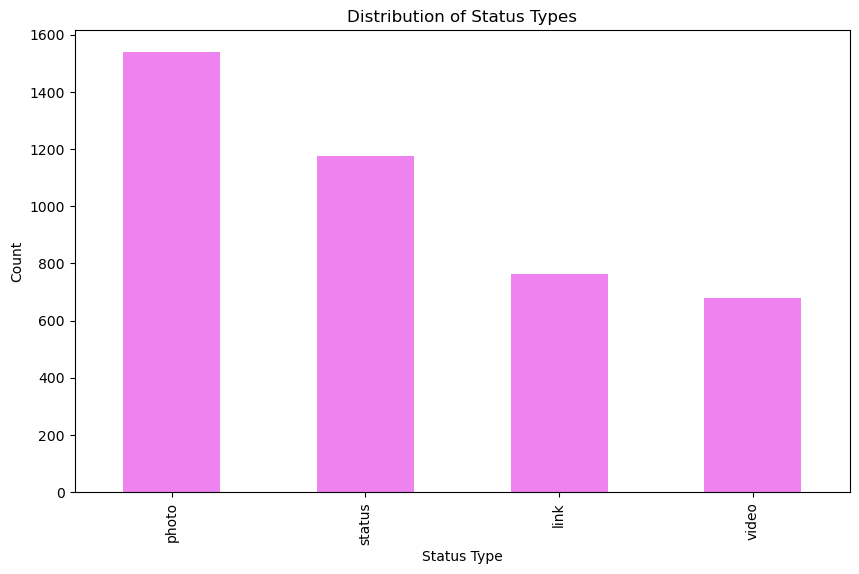

In [7]:
# Distribution of types of statuses (photo, video, link, and status)
status_types = data['status_type'].value_counts()
plt.figure(figsize=(10, 6))
status_types.plot(kind='bar', color='violet')
plt.title('Distribution of Status Types')
plt.xlabel('Status Type')
plt.ylabel('Count')
plt.show()

## <span style="color:orange;">QUESTION 2: Plot a chart showing the progression of likes, loves, and sads, and angrys over time.</span>

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

data['status_published'] = pd.to_datetime(data['status_published'])

# Set 'status_published' as the index
data.set_index('status_published', inplace=True)

In [9]:
# Resample data to a weekly frequency
weekly_data = data.resample('W').sum()

reactions = ['num_likes', 'num_loves', 'num_sads', 'num_angrys']

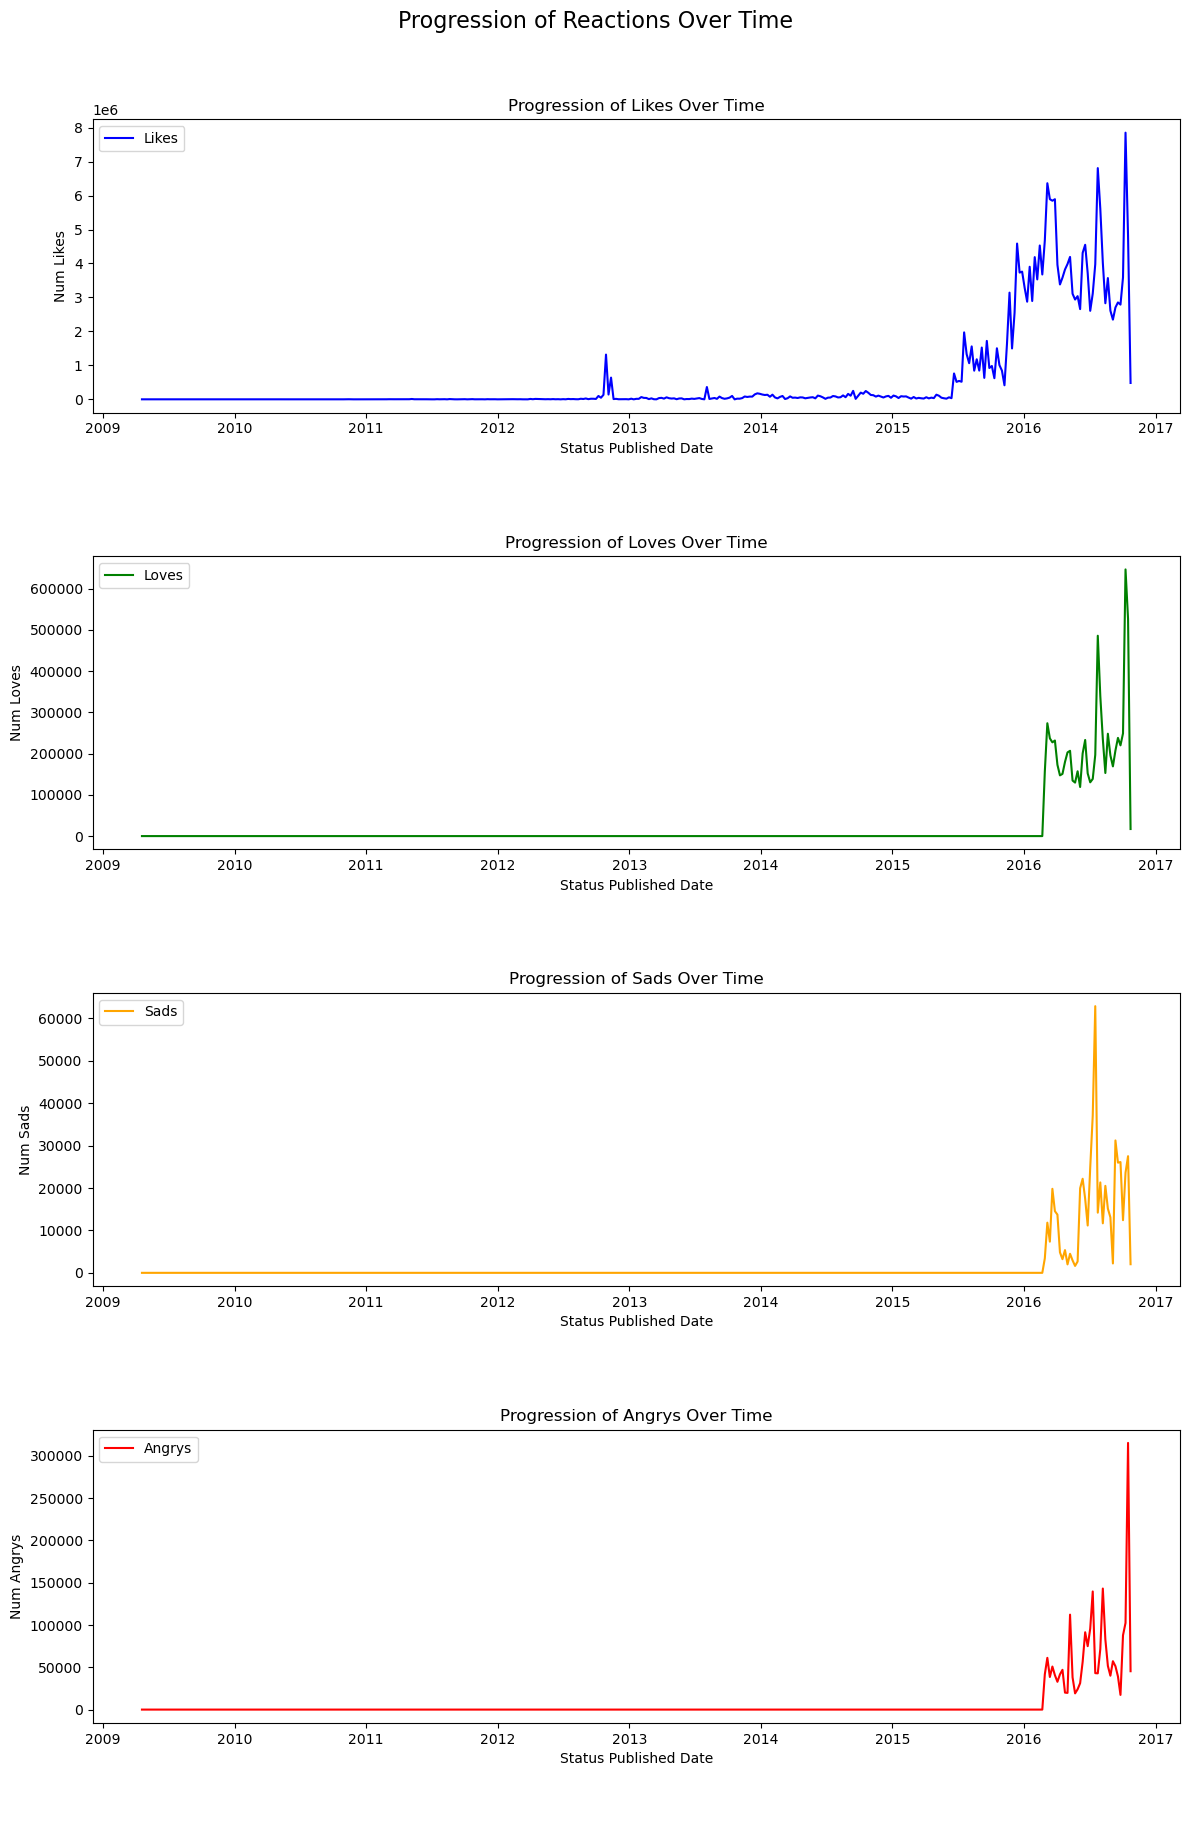

In [10]:
# Create subplots for each reaction
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 18), sharex=False)

# Plotting the progression of likes, loves, sads, and angrys over time
axes[0].plot(weekly_data.index, weekly_data['num_likes'], label='Likes', color='blue')
axes[1].plot(weekly_data.index, weekly_data['num_loves'], label='Loves', color='green')
axes[2].plot(weekly_data.index, weekly_data['num_sads'], label='Sads', color='orange')
axes[3].plot(weekly_data.index, weekly_data['num_angrys'], label='Angrys', color='red')

# Adjust subplot settings
for i, (ax, reaction) in enumerate(zip(axes, ['Likes', 'Loves', 'Sads', 'Angrys'])):
    ax.set_ylabel(f'Num {reaction}')
    ax.legend()
    ax.set_title(f'Progression of {reaction} Over Time')
    ax.set_xlabel('Status Published Date\n\n\n\n')

plt.suptitle('Progression of Reactions Over Time', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


## <span style="color:orange;">QUESTION 3: What are the top reactions expressed by Trump’s Facebook audience?</span>

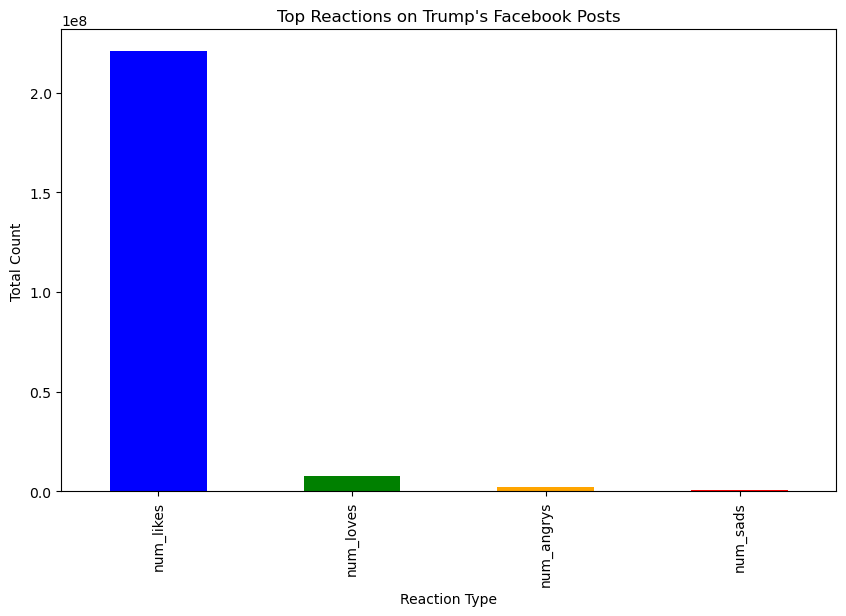

Top Reactions:
num_likes     220669482.0
num_loves       7706060.0
num_angrys      2269144.0
num_sads         540292.0
dtype: float64


In [11]:
# Sum the counts for each reaction type
total_reactions = data[['num_likes', 'num_loves', 'num_sads', 'num_angrys']].sum()

# Sort reactions in descending order
top_reactions = total_reactions.sort_values(ascending=False)

# Plot the top reactions
plt.figure(figsize=(10, 6))
top_reactions.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Top Reactions on Trump\'s Facebook Posts')
plt.xlabel('Reaction Type')
plt.ylabel('Total Count')
plt.show()

# Display the top reactions and their counts
print("Top Reactions:")
print(top_reactions)


## <span style="color:orange;">QUESTION 4: What are the themes (topics or top words) that generated a lot of shares?</span>

## Cleaning and prerpcessing

In [12]:
data = data.reset_index(drop=True)

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

def preprocess_and_tokenize(txt):
    # Clean text
    txt = clean_text(txt)
    
    # Stop word removal and length filtering
    stop_words = set(stopwords.words('english'))
    filtered_text = [word for word in word_tokenize(txt) if word.isalnum() and len(word) > 3 and word.lower() not in stop_words]
    
    # Lowercase change and lemmatization using WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_text]
    txt = ' '.join(lemmatized_words).lower()
    
    # Tokenize, remove stopwords, and lemmatize again
    words = word_tokenize(txt)
    final_tokens = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word.lower() not in stop_words]

    return final_tokens

# Combine status messages with a high number of shares
high_share_messages = data[data['num_shares'] > data['num_shares'].quantile(0.75)]['status_message']

# Tokenize and preprocess the text
tokens = high_share_messages.dropna().apply(preprocess_and_tokenize)

## World Cloud of topics with having a high number of shares.

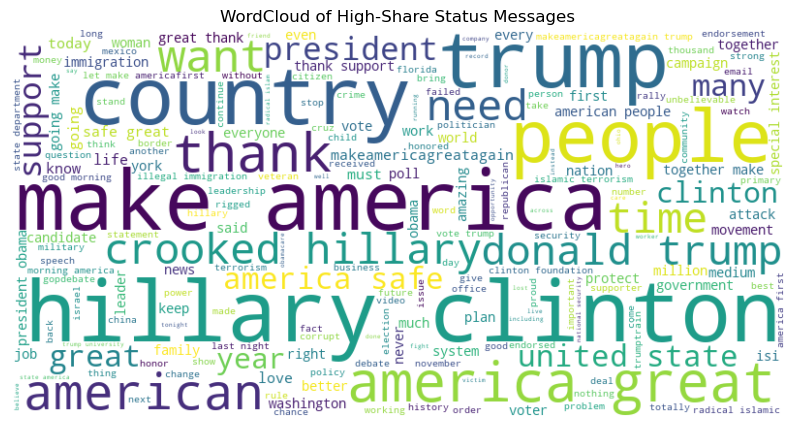

In [13]:
# Combine tokens into a single list of strings for WordCloud
flat_tokens = [word for sublist in tokens for word in sublist]
text_for_wordcloud = ' '.join(flat_tokens)

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of High-Share Status Messages')
plt.show()


## Finding the optimal number for topics with CoherenceModel

In [14]:
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)
bag_word = [dictionary.doc2bow(token) for token in tokens]

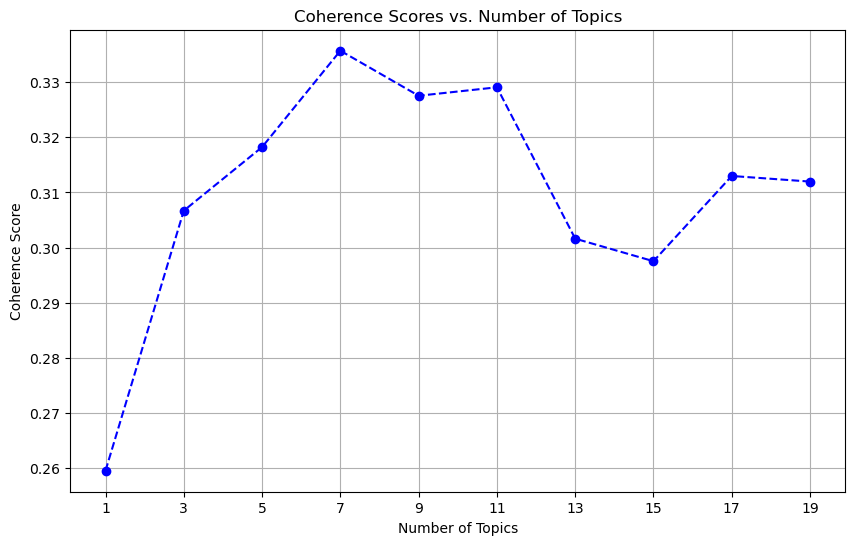

In [15]:
coherence_scores = []
for num_topics in range(1, 20, 2): 
    lda_model = gensim.models.LdaMulticore(corpus=bag_word, num_topics=num_topics, id2word=dictionary, passes=5, workers=2)
    coherence_model = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20, 2), coherence_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores vs. Number of Topics")
plt.xticks(range(1, 20, 2))
plt.grid(True)
plt.show()


## <span style="color:brown;">Method 1: Retrieve topics with having a high number of shares using LdaMulticore.</span>

In [16]:
lda_ml = gensim.models.LdaMulticore(corpus=bag_word, num_topics=7, id2word = dictionary, passes = 50, workers=2)

In [17]:
# Get the topics and their top keywords
topics = lda_ml.print_topics(num_words=10)

# Display the topics and their top keywords
for topic in topics:
    topic_index, topic_keywords = topic
    keyword_list = ', '.join([word.split('*')[1].strip() for word in topic_keywords.split('+')])
    print(f'Topic {topic_index}: {keyword_list}')



Topic 0: "state", "crooked", "united", "american", "want", "system", "email", "rigged", "obama", "medium"
Topic 1: "campaign", "cruz", "vote", "let", "candidate", "obama", "endorsement", "york", "like", "tuesday"
Topic 2: "going", "need", "leadership", "special", "year", "watch", "take", "interest", "look", "politician"
Topic 3: "american", "radical", "terrorism", "islamic", "must", "need", "security", "plan", "immigration", "better"
Topic 4: "million", "american", "republican", "right", "foundation", "immigration", "government", "party", "time", "illegal"
Topic 5: "love", "last", "time", "night", "florida", "amazing", "americafirst", "join", "life", "movement"
Topic 6: "together", "safe", "poll", "good", "morning", "going", "vote", "movement", "keep", "number"


## <span style="color:brown;">Method 2: Retrieve topics with having a high number of shares using LatentDirichletAllocation.</span>

In [18]:
# Combine tokens into a single string for analysis
text_for_analysis = [' '.join(token_list) for token_list in tokens]

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_for_analysis)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics = 7
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
topics = {}
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topics[f'Topic {topic_idx + 1}'] = top_words

# Print the top words for each topic
for topic, top_words in topics.items():
    print(f"{topic}: {', '.join(top_words)}")


Topic 1: trump, donald, makeamericagreatagain, republican, great, party, country, state, campaign, cruz
Topic 2: country, trump, people, makeamericagreatagain, politician, need, veteran, special, interest, time
Topic 3: trump, president, obama, american, university, carolina, hillary, makeamericagreatagain, need, correct
Topic 4: hillary, crooked, clinton, trump, medium, obamacare, never, news, obama, immediately
Topic 5: clinton, hillary, american, people, country, state, rigged, america, president, system
Topic 6: america, great, thank, make, support, safe, together, poll, love, going
Topic 7: people, clinton, country, american, america, hillary, radical, state, president, want


## <span style="color:orange;">QUESTION 5: What are the themes (topics or top words) that generated a lot of num_reactions?</span>

In [19]:
# Combine status messages with a high number of reactions
high_react = data[data[['num_likes', 'num_loves', 'num_sads', 'num_angrys']].sum(axis=1) > data[['num_likes', 'num_loves', 'num_sads', 'num_angrys']].sum(axis=1).quantile(0.75)]['status_message']

# Tokenize and preprocess the text
tokens2 = high_react.dropna().apply(preprocess_and_tokenize)


## World Cloud of topics with having a high number of reactions.

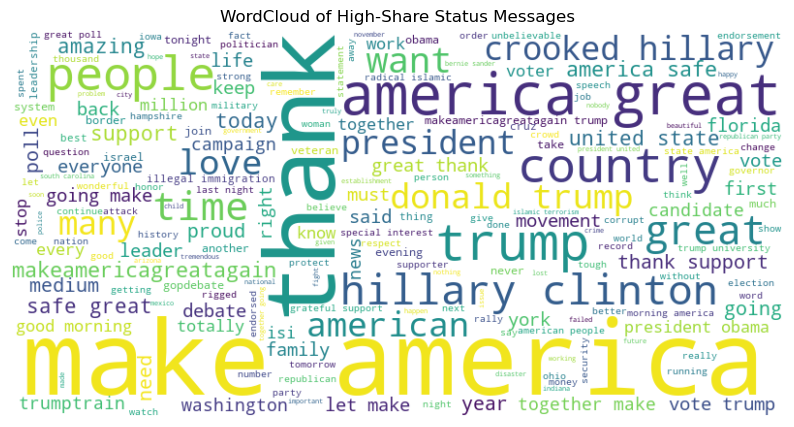

In [20]:
# Combine tokens into a single list of strings for WordCloud
flat_tokens2 = [word for sublist in tokens2 for word in sublist]
text_for_wordcloud2 = ' '.join(flat_tokens2)

# Generate WordCloud
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud2)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of High-Share Status Messages')
plt.show()

## Finding the optimal number for topics with CoherenceModel

In [21]:
dictionary2 = gensim.corpora.Dictionary(tokens2)
dictionary2.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)
bag_word2 = [dictionary2.doc2bow(token) for token in tokens2]

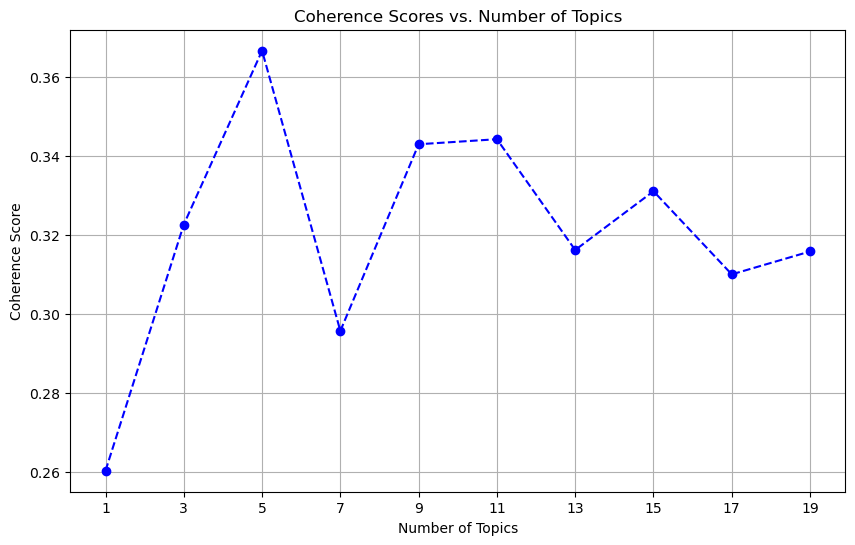

In [26]:
coherence_scores2 = []
for num_topics in range(1, 20, 2): 
    lda_model2 = gensim.models.LdaMulticore(corpus=bag_word2, num_topics=num_topics, id2word=dictionary2, passes=5, workers=2)
    coherence_model2 = CoherenceModel(model=lda_model2, texts=tokens2, dictionary=dictionary2, coherence='c_v')
    coherence_score2 = coherence_model2.get_coherence()
    coherence_scores2.append(coherence_score2)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20, 2), coherence_scores2, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores vs. Number of Topics")
plt.xticks(range(1, 20, 2))
plt.grid(True)
plt.show()


## <span style="color:brown;">Method 1: Retrieve topics with having a high number of reactions using LdaMulticore.</span>

In [27]:
lda_ml2 = gensim.models.LdaMulticore(corpus=bag_word2, num_topics=5, id2word = dictionary2, passes = 50, workers=2)
# Get the topics and their top keywords
topics2 = lda_ml2.print_topics(num_words=10)

# Display the topics and their top keywords
for topic in topics2:
    topic_index, topic_keywords = topic
    keyword_list = ', '.join([word.split('*')[1].strip() for word in topic_keywords.split('+')])
    print(f'Topic {topic_index}: {keyword_list}')

Topic 0: "crooked", "poll", "special", "last", "debate", "interest", "night", "running", "like", "news"
Topic 1: "would", "back", "many", "time", "cruz", "job", "take", "million", "republican", "stop"
Topic 2: "state", "united", "proud", "donald", "family", "honor", "border", "work", "governor", "endorsement"
Topic 3: "american", "want", "need", "obama", "life", "york", "every", "thing", "leadership", "attack"
Topic 4: "makeamericagreatagain", "going", "together", "safe", "let", "vote", "love", "good", "everyone", "florida"


## <span style="color:brown;">Method 2: Retrieve topics with having a high number of reactions using LatentDirichletAllocation.</span>

In [28]:
# Combine tokens into a single string for analysis
text_for_analysis2 = [' '.join(token_list) for token_list in tokens2]

# Vectorize the text using CountVectorizer
vectorizer2 = CountVectorizer()
X2 = vectorizer2.fit_transform(text_for_analysis2)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics2 = 5
lda2 = LatentDirichletAllocation(n_components=num_topics2, random_state=42)
lda2.fit(X2)

# Display the top words for each topic
feature_names2 = vectorizer2.get_feature_names_out()
topics2 = {}
for topic_idx, topic in enumerate(lda2.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names2[i] for i in top_words_idx]
    topics2[f'Topic {topic_idx + 1}'] = top_words

# Print the top words for each topic
for topic, top_words in topics2.items():
    print(f"{topic}: {', '.join(top_words)}")

Topic 1: trump, president, israel, university, people, obama, work, makeamericagreatagain, american, state
Topic 2: hillary, clinton, crooked, great, people, time, rigged, many, america, american
Topic 3: hillary, clinton, people, country, want, president, american, need, trump, going
Topic 4: trump, makeamericagreatagain, president, people, country, life, interest, special, american, great
Topic 5: great, america, thank, make, trump, support, love, together, safe, going
